<a href="https://colab.research.google.com/github/Chiebukar/Deep-Learning/blob/main/Human_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Facial Emotion Recognition

### **Get Dataset from Kaggle**

In [ ]:
# Upload kaggle.json file key
from google.colab import files
files.upload()

In [2]:
# make new kaggle directory
!mkdir -p ~/.kaggle

# Copy kaggle.json file to kaggle directory
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download the datasets from kaggle
!kaggle datasets download -d shawon10/ckplus

  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 59.5MB/s]


In [4]:
# list files in directory
!ls -d  $PWD/*

/content/ckplus.zip  /content/kaggle.json  /content/sample_data


In [ ]:
# unzip zip file with dataset
!unzip \*.zip && rm *.zip

In [6]:
# view files in current directory
!ls -d $PWD/*

/content/ck  /content/CK+48  /content/kaggle.json  /content/sample_data


In [7]:
#view files in dataset directory
!ls -d $PWD/CK+48/*

/content/CK+48/anger	 /content/CK+48/fear	 /content/CK+48/surprise
/content/CK+48/contempt  /content/CK+48/happy
/content/CK+48/disgust	 /content/CK+48/sadness


In [8]:
# store dataset path
data_dir = '/content/CK+48/'

### **Import Required**

In [9]:
# import required datasets
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Dense, MaxPooling2D,  Flatten, Dropout,  Activation
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### **Load Images and Labels**

In [10]:
# show unique classes in dataset directory
classes = os.listdir(data_dir)
classes

['disgust', 'happy', 'sadness', 'contempt', 'anger', 'surprise', 'fear']

In [11]:
# create dictioary of classes and labels
class_dict = {'disgust': 0,'sadness':1, 'anger':2, 'happy':3, 'contempt':4, 'fear': 5, 'surprise':6 }

In [12]:
# function to load images and labels as list
def load_images(path):
  features = []
  targets = []
  labels = os.listdir(path)
  for label in labels:
    label_path = path + label + '/'
    img_dirs = os.listdir(label_path)
    num = len(img_dirs)
    print('discovered {} images in {} folder'.format(num,label))
    print('Loading images from {} into features and labels set...'.format(label))
    for dir in img_dirs:
      img_path  = label_path + dir
      image = cv2.imread(img_path)
      resized_image  = cv2.resize(image, (48,48))
      features.append(np.array(resized_image))
      targets.append(class_dict[label])
  print('Completed loading images')
  return features, targets

In [13]:
# load images and labels as features and targets
features, targets = load_images(data_dir)

discovered 177 images in disgust folder
Loading images from disgust into features and labels set...
discovered 207 images in happy folder
Loading images from happy into features and labels set...
discovered 84 images in sadness folder
Loading images from sadness into features and labels set...
discovered 54 images in contempt folder
Loading images from contempt into features and labels set...
discovered 135 images in anger folder
Loading images from anger into features and labels set...
discovered 249 images in surprise folder
Loading images from surprise into features and labels set...
discovered 75 images in fear folder
Loading images from fear into features and labels set...
Completed loading images


In [14]:
# show length of features and targets
print('Length of features: {}'.format(len(features)))
print('Length of targets: {}'.format(len(targets)))

Length of features: 981
Length of targets: 981


In [15]:
# get input shape
input_shape = features[0].shape
print('shape of each item in features: {}'.format(input_shape))

shape of each item in features: (48, 48, 3)


### **Explore Data and Display Images**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


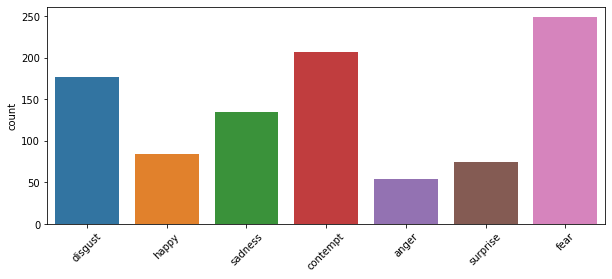

In [16]:
# plot distribution of classes in dataset
plt.figure(figsize=(10,4))
sns.countplot(pd.Series(targets))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.show()

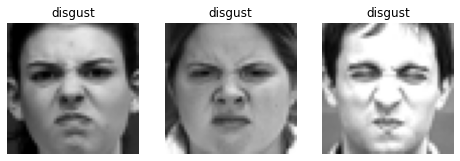

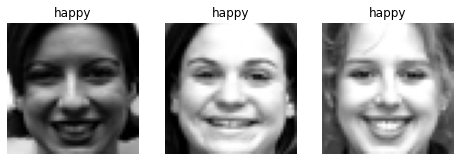

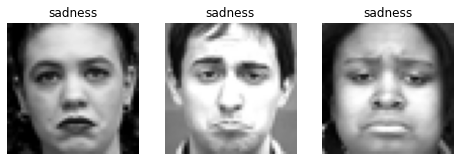

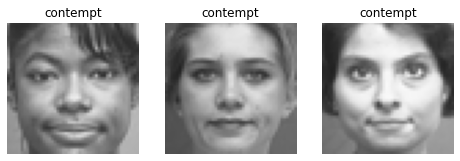

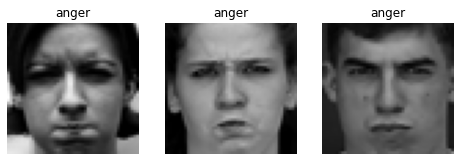

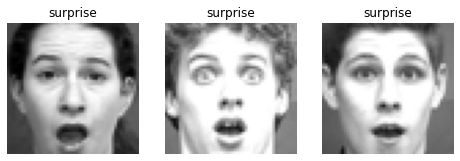

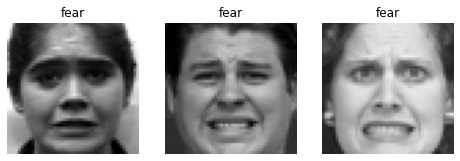

In [17]:
# display images  by classes from datasets
for i, class_name in enumerate(classes):
  label_path = data_dir + class_name + '/'
  img_dirs = os.listdir(label_path)[:3] 
  fig = plt.figure(figsize = (8,5))
  for j, image  in enumerate(img_dirs):
    image_path = label_path + image
    img = cv2.imread(image_path) 
    fig.add_subplot(1,3, j+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

### **Data Preprocessing**

In [18]:
# change feaures and targetsto arrays
features = np.array(features)
targets =  np.array(targets)

In [19]:
# shuffle data in features and targets
features, targets = shuffle(features, targets, random_state = 0, stratify = targets)

In [20]:
# split dataset into train and test data
X_train, X_val, y_train, y_val = train_test_split(features, targets, random_state = 0, test_size = 0.1, stratify = targets)

In [21]:
# show shape of train and test data
X_train.shape ,y_train.shape, X_val.shape, y_val.shape

((882, 48, 48, 3), (882,), (99, 48, 48, 3), (99,))

In [22]:
# normaalise features set
X_train = X_train/255
X_val = X_val/255

In [23]:
# one hot encode targets set 
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

### **Data Augmentation**

In [24]:
# initialize image data generator for training and validation sets
train_gen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip=True,
                                vertical_flip = True)

val_gen = ImageDataGenerator()

In [25]:
# apply data augmentation to features
BATCH_SIZE= 16
train_datagen = train_gen.flow(X_train, y_train, batch_size= BATCH_SIZE)
val_datagen = val_gen.flow(X_val, y_val, batch_size= BATCH_SIZE)

### **Build and Train Model**

In [26]:
# function to build model
def build_model():
  input = Input((input_shape))
  x = Conv2D(32, (3,3))(input)
  x = Activation('relu')(x)
  x = Dropout(0.01)(x)
  x = MaxPooling2D((2,2))(x)

  x = Conv2D(64, (3,3))(x)
  x = Activation('relu')(x)
  x = Dropout(0.01)(x)
  x = MaxPooling2D((2,2))(x)


  x = Conv2D(128, (3,3))(x)
  x = Activation('relu')(x)
  x = Dropout(0.01)(x)
  x = MaxPooling2D((2,2))(x)


  x = Conv2D(256, (3,3))(x)
  x = Activation('relu')(x)
  x = Dropout(0.01)(x)
  x = MaxPooling2D((2,2))(x)


  x = Flatten()(x)

  x = Dense(128)(x)
  x = Activation('relu')(x)
  x = Dropout(0.2)(x)

  x = Dense(7)(x)
  output = Activation('softmax')(x)

  model = Model(input, output)

  return model

In [27]:
# initialize model
model = build_model()

In [28]:
# display model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 46, 46, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 21, 21, 64)        0     

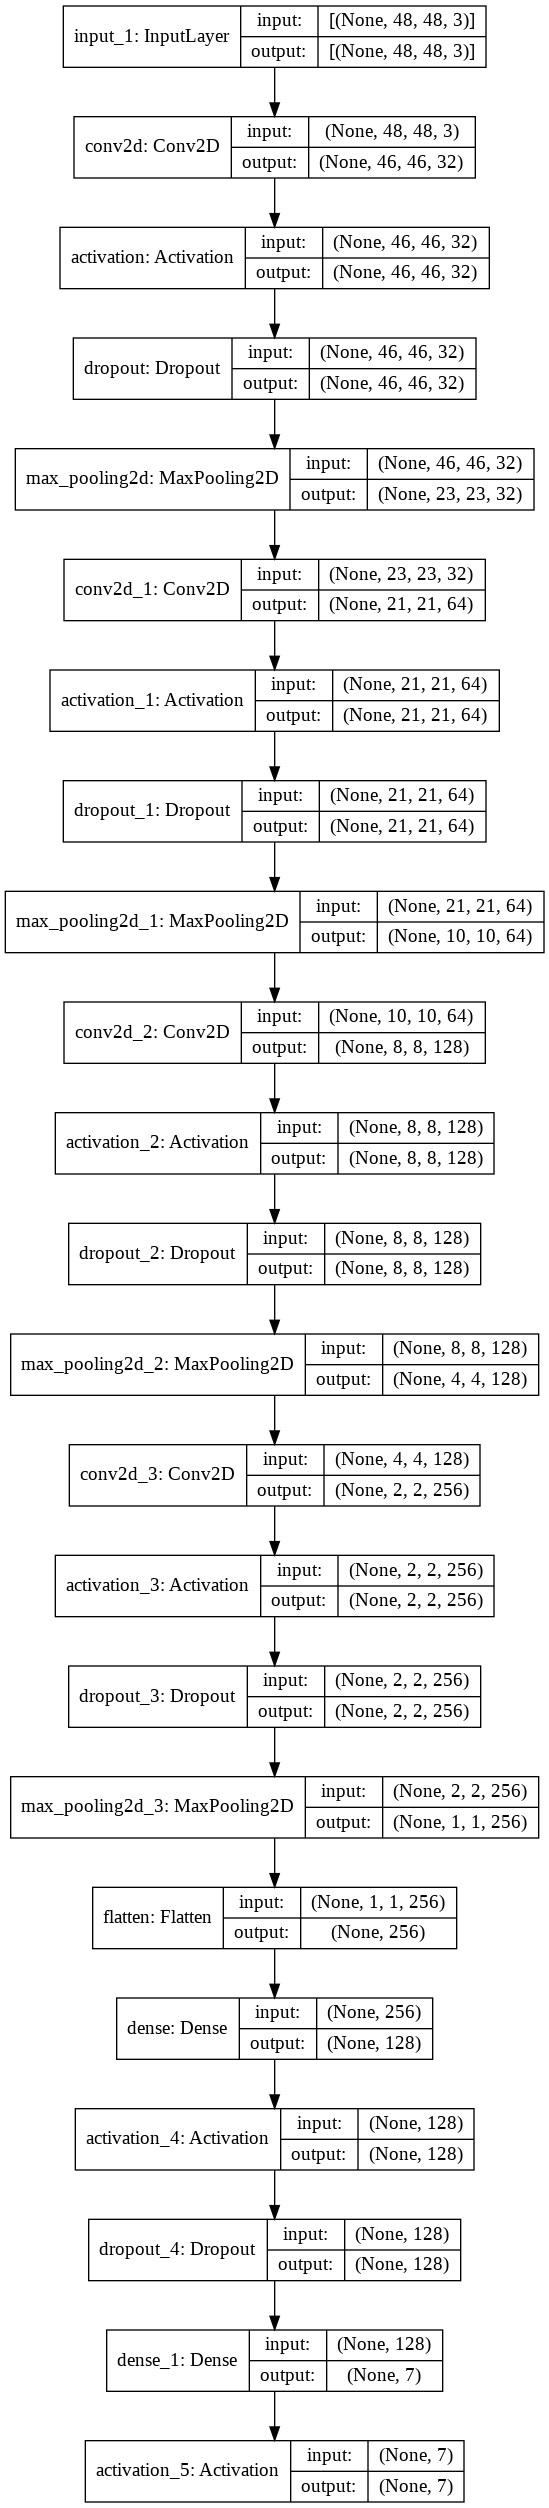

In [29]:
# plot model achitecture
plot_model(model, 'Model.png',show_shapes=True)

In [30]:
# initialize optimizer
adam = keras.optimizers.Adam(learning_rate=0.0001)

# compile model
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

In [31]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=50, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_acc', patience = 120, verbose=1, mode='max', restore_best_weights= True)

checkpoint = ModelCheckpoint('model.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min')

In [ ]:
# train model
history = model.fit(train_datagen, epochs= 1000,
                    steps_per_epoch = len(X_train)// BATCH_SIZE,
                    validation_data = val_datagen, 
                    validation_steps = len(X_val)//BATCH_SIZE,
                    callbacks= [reduceLR, early_stopping, checkpoint])

In [33]:
# read training history into dataframe
history_df = pd.DataFrame(history.history)

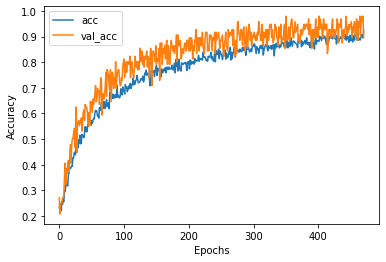

In [37]:
# dispay training history
history_df[['acc', 'val_acc']].plot()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [38]:
# load best weights to model
model.load_weights('model.weights.hdf5')

In [39]:
# evaluate model
model.evaluate(X_val,y_val)

4/4 [==============================] - 0s 25ms/step - loss: 0.1095 - acc: 0.9798


[0.10949286073446274, 0.9797979593276978]

In [40]:
# get predicted labels
y_test_pred = model.predict(X_val)
y_test_pred[:3]

array([[3.7875911e-09, 4.3095763e-11, 1.5895693e-13, 9.9999154e-01,
        3.3156702e-10, 8.1700755e-06, 2.6611346e-07],
       [6.2740866e-05, 7.1673238e-01, 2.8320441e-01, 1.3026665e-14,
        1.2574670e-09, 2.9712558e-07, 1.7160332e-07],
       [6.8914346e-06, 1.9315208e-01, 8.0682492e-01, 1.2992637e-11,
        2.5197915e-07, 1.5551295e-05, 2.0781988e-07]], dtype=float32)

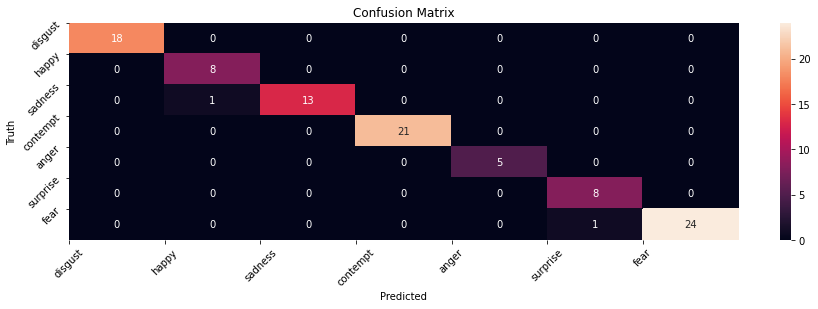

In [41]:
# visualize confusion matrix

plt.figure(figsize=(15,4))
cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_test_pred, axis =1))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title ('Confusion Matrix')

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes, rotation=45)
plt.show()

In [42]:
# display classification report
print(classification_report(np.argmax(y_val, axis=1), np.argmax(y_test_pred, axis =1), target_names= classes))

              precision    recall  f1-score   support

     disgust       1.00      1.00      1.00        18
       happy       0.89      1.00      0.94         8
     sadness       1.00      0.93      0.96        14
    contempt       1.00      1.00      1.00        21
       anger       1.00      1.00      1.00         5
    surprise       0.89      1.00      0.94         8
        fear       1.00      0.96      0.98        25

    accuracy                           0.98        99
   macro avg       0.97      0.98      0.97        99
weighted avg       0.98      0.98      0.98        99

